In [1]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow
from torchsummary import summary

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
img_size = 128
latent_dim = 128
batch_size = 64
model_path = "vae_final.pt"
test_root = r"D:\projects\xray\test"
output_csv = "anomaly_scores.csv"
print(device)

cpu


In [3]:
class UnlabeledImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(dp, f)
            for dp, dn, filenames in os.walk(root_dir)
            for f in filenames if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

test_dataset = UnlabeledImageDataset(test_root, transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

NameError: name 'transforms' is not defined

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU(True)
        )
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 256 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 256, 8, 8)
        return self.decoder(x)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [5]:
model = VAE(latent_dim).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc_mu): Linear(in_features=16384, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=16384, out_features=128, bias=True)
  (fc_decode): Linear(in_features=128, out_features=16384, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): R

In [6]:
all_paths, recon_errors, mahal_scores = [], [], []
latents = []

with torch.no_grad():
    for imgs, paths in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(device)
        recon, mu, logvar = model(imgs)
        loss = torch.mean((recon - imgs) ** 2, dim=[1, 2, 3])
        recon_errors.extend(loss.cpu().numpy())
        latents.append(mu.cpu().numpy())
        all_paths.extend(paths)

latents = np.concatenate(latents, axis=0)
cov = np.cov(latents, rowvar=False)
inv_cov = np.linalg.pinv(cov)
mean_latent = np.mean(latents, axis=0)

for z in tqdm(latents, desc="Mahalanobis"):
    m = mahalanobis(z, mean_latent, inv_cov)
    mahal_scores.append(m)

Mahalanobis: 100%|███████████████████████████████████████████████████████████████| 4324/4324 [00:00<00:00, 9035.00it/s]


In [7]:
df = pd.DataFrame({
    "image_path": all_paths,
    "reconstruction_error": recon_errors,
    "mahalanobis_distance": mahal_scores
})
df["combined_score"] = df["reconstruction_error"] + 0.01 * df["mahalanobis_distance"]
df.sort_values("combined_score", ascending=False, inplace=True)
df.to_csv(output_csv, index=False)

top_dir = "top_anomalies"
os.makedirs(top_dir, exist_ok=True)
for i, row in df.head(20).iterrows():
    name = os.path.basename(row["image_path"])
    dest = os.path.join(top_dir, f"{i:03d}_{name}")
    os.makedirs(os.path.dirname(dest), exist_ok=True)
    try:
        Image.open(row["image_path"]).save(dest)
    except:
        continue

print("Saved anomaly scores to", output_csv)
print("Top anomalies saved to", top_dir)

Saved anomaly scores to anomaly_scores.csv
Top anomalies saved to top_anomalies


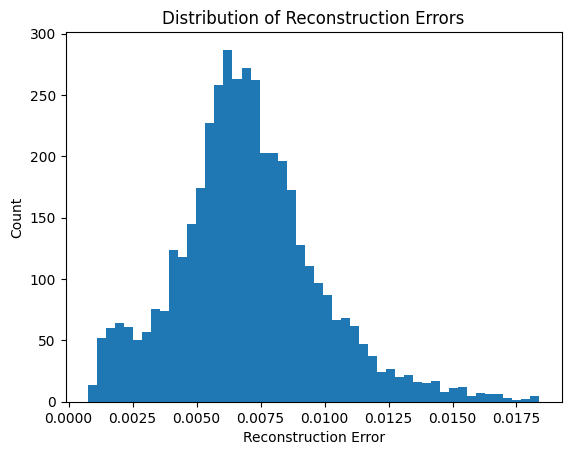

Threshold (95th percentile): 0.011952944286167609


In [8]:
model.eval()
reconstruction_errors = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        recon_images, _, _ = model(images)
        errors = torch.mean((images - recon_images) ** 2, dim=[1, 2, 3])
        reconstruction_errors.extend(errors.cpu().numpy())

reconstruction_errors = np.array(reconstruction_errors)

plt.hist(reconstruction_errors, bins=50)
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.title("Distribution of Reconstruction Errors")
plt.show()

threshold = np.percentile(reconstruction_errors, 95)
print("Threshold (95th percentile):", threshold)

In [17]:
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,568
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 32, 32]          32,832
              ReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 16, 16]         131,200
              ReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,544
              ReLU-8            [-1, 256, 8, 8]               0
            Linear-9                  [-1, 128]       2,097,280
           Linear-10                  [-1, 128]       2,097,280
           Linear-11                [-1, 16384]       2,113,536
  ConvTranspose2d-12          [-1, 128, 16, 16]         524,416
             ReLU-13          [-1, 128, 16, 16]               0
  ConvTranspose2d-14           [-1, 64,